In [2]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)
import seaborn as sns
import tensorflow as tf 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#tf.enable_eager_execution()
sns.set(style='white',  font='sans-serif', font_scale=1.5)


In [3]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from scipy.stats.stats import pearsonr
from copy import copy
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def roc_auc(y_true, y_score):
    return roc_auc_score(y_true, y_score)


def ForwardPropFeatureImp(model, X_true, Y_true, df_grid):
    '''
    Forward prop. Feature importance
    '''

    df_grid = df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = sigmoid(model.predict(X_true))
    loss = log_loss(Y_true, Y_prob)
    N, W, H, C = X_true.shape
    results = []
    for i in tqdm(range(len(df_grid)), ascii= True):
        ts = df_grid.iloc[i]
        y = ts.y
        x = ts.x
        X1 = copy(X_true)
        X1[:, y, x,:] = np.zeros(X1[:, y, x,:].shape)
        #Y1 = model.predict(X1)
        Y_pred_prob = sigmoid(model.predict(X1))
        mut_loss = log_loss(Y_true, Y_pred_prob)
        res =  mut_loss - loss # if res > 0, important, othervise, not important

        results.append(res)
        
    S = pd.Series(results, name = 'importance')
    df = df_grid.join(S)
    return df

## Input feature maps

In [4]:
smiles = ['CC(=O)OC1=CC=CC=C1C(O)=O']
mp2 = loadmap('../optimized_fingerprint.mp')

In [5]:
from molmap.model.loss import cross_entropy
model_name = './model.h5'
model = load_model(model_name, compile=False)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = opt, loss = cross_entropy)

In [6]:
from chembench import dataset, load_data
#load dataset
data = dataset.load_BACE()
df = data.df
Y = data.y
task_name = data.task_name

train_df = pd.read_csv('../data/train.csv')
valid_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')


train_idx = df[df.smiles.isin(train_df.smiles)].index
valid_idx = df[df.smiles.isin(valid_df.smiles)].index
test_idx = df[df.smiles.isin(test_df.smiles)].index

total samples: 1513


In [7]:
X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
trainX = X2[train_idx]
trainY = Y[train_idx]

validX = X2[valid_idx]
validY = Y[valid_idx]

testX = X2[test_idx]
testY = Y[test_idx]

100%|##########| 1513/1513 [00:53<00:00, 28.27it/s]


## The GMP 192 pca

In [8]:
def GetGMP192(X):
    layer = model.get_layer('global_max_pooling2d')
    activation_model = Model(inputs=model.input, outputs=layer.output)
    activation = activation_model.predict(X, batch_size = 128)
    return activation

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

In [10]:
X192 = GetGMP192(X2)
pca = PCA(n_components=2,  random_state = 2) #random_state = 2
X192.shape

(1513, 192)

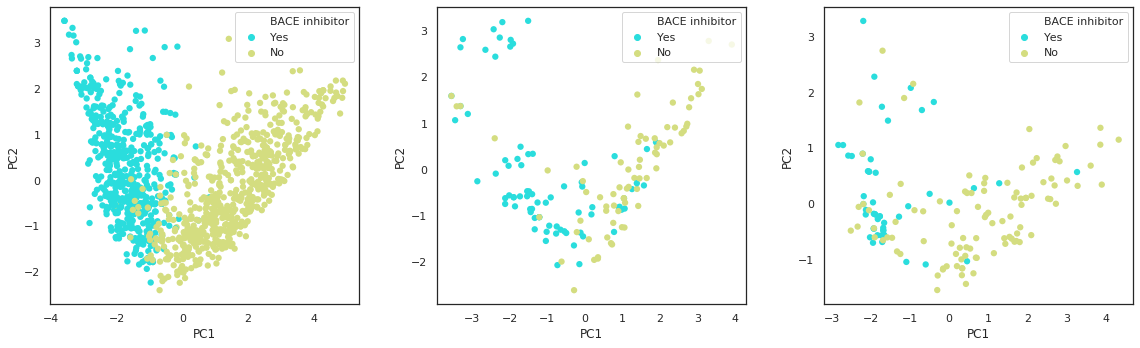

In [12]:
f, axes = plt.subplots(1, 3, figsize=(16,5))
sns.set(style='white',  font='sans-serif', font_scale=1.5)

i = 0
for idx, ax in  zip([train_idx, valid_idx, test_idx], axes):

    embedd_2d = pca.fit_transform(X192[idx])
    dft = pd.DataFrame(embedd_2d, columns = ['PC1', 'PC2'])
    name = 'BACE inhibitor'
    dft[name] = Y[idx]
    dft[name] = dft[name].map({0:"No", 1:"Yes"})
    sns.set(style="white")
#     if i == 1:
#         dft.PC1 = -dft.PC1
    _ = sns.scatterplot('PC1','PC2',  hue = name, palette = 'rainbow', s = 40,  linewidth = 0, data = dft, ax = ax, ) #hue_order = order
    i += 1

    ax.legend(loc= 'upper right')
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

plt.savefig('../result/global_max_pooling_192D_new.svg', bbox_inches="tight", dpi = 400)

## The Leave One Out feature importance

In [11]:
n, w, h, c = trainX.shape
mp2.plot_grid()
df_grid = mp2.df_grid

2020-09-21 16:05:53,743 - INFO - [bidd-molmap] - generate file: ./fingerprint_1303_cosine_umap_molmap
2020-09-21 16:05:53,997 - INFO - [bidd-molmap] - save html file to ./fingerprint_1303_cosine_umap_molmap


In [12]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from scipy.stats.stats import pearsonr
from copy import copy
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def roc_auc(y_true, y_score):
    return roc_auc_score(y_true, y_score)


def ForwardPropFeatureImp(model, X_true, Y_true, df_grid):
    '''
    Forward prop. Feature importance
    '''

    df_grid = df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = sigmoid(model.predict(X_true))
    loss = log_loss(Y_true, Y_prob)
    N, W, H, C = X_true.shape
    results = []
    for i in tqdm(range(len(df_grid)), ascii= True):
        ts = df_grid.iloc[i]
        y = ts.y
        x = ts.x
        X1 = copy(X_true)
        X1[:, y, x,:] = np.zeros(X1[:, y, x,:].shape)
        #Y1 = model.predict(X1)
        Y_pred_prob = sigmoid(model.predict(X1))
        mut_loss = log_loss(Y_true, Y_pred_prob)
        res =  mut_loss - loss # if res > 0, important, othervise, not important

        results.append(res)
        
    S = pd.Series(results, name = 'importance')
    df = df_grid.join(S)
    return df

In [13]:
train_imp = ForwardPropFeatureImp(model, trainX, trainY,  df_grid)
test_imp = ForwardPropFeatureImp(model, testX, testY,  df_grid)

100%|##########| 1332/1332 [01:26<00:00, 15.39it/s]


In [14]:
train_imp.sort_values('importance',ascending=False)

,x,y,v,Subtypes,colors,importance
1057,13,29,PubChemFP797,PubChemFP,#d600ff,0.051609
1132,16,31,PubChemFP734,PubChemFP,#d600ff,0.047897
1049,5,29,PharmacoErGFP148,PharmacoErGFP,#003fff,0.046328
1125,9,31,MACCSFP84,MACCSFP,#00c7ff,0.044342
1090,10,30,PharmacoErGFP24,PharmacoErGFP,#003fff,0.039897
...,...,...,...,...,...,...
1030,22,28,PubChemFP592,PubChemFP,#d600ff,-0.016283
994,22,27,PubChemFP345,PubChemFP,#d600ff,-0.016469
1206,18,33,PubChemFP502,PubChemFP,#d600ff,-0.016567
920,20,25,MACCSFP111,MACCSFP,#00c7ff,-0.017965


In [15]:
cols = ['Feature importance based on training set',  'Feature importance based on test set' ] 

In [16]:
dfp = pd.DataFrame([train_imp.importance.tolist(), 
                      test_imp.importance.tolist()], index = cols, columns = train_imp.v).T 

dfp['Subtypes'] = train_imp.Subtypes.tolist()
dfp['colors'] = train_imp.colors.tolist()
colormaps_all = mp2.extract.colormaps

In [17]:
colormaps = {}
for i in mp2.df_grid.Subtypes.unique():
    colormaps[i] = colormaps_all[i]
colormaps

{'PharmacoErGFP': '#003fff',
 'PubChemFP': '#d600ff',
 'MACCSFP': '#00c7ff',
 'NaN': '#000000'}

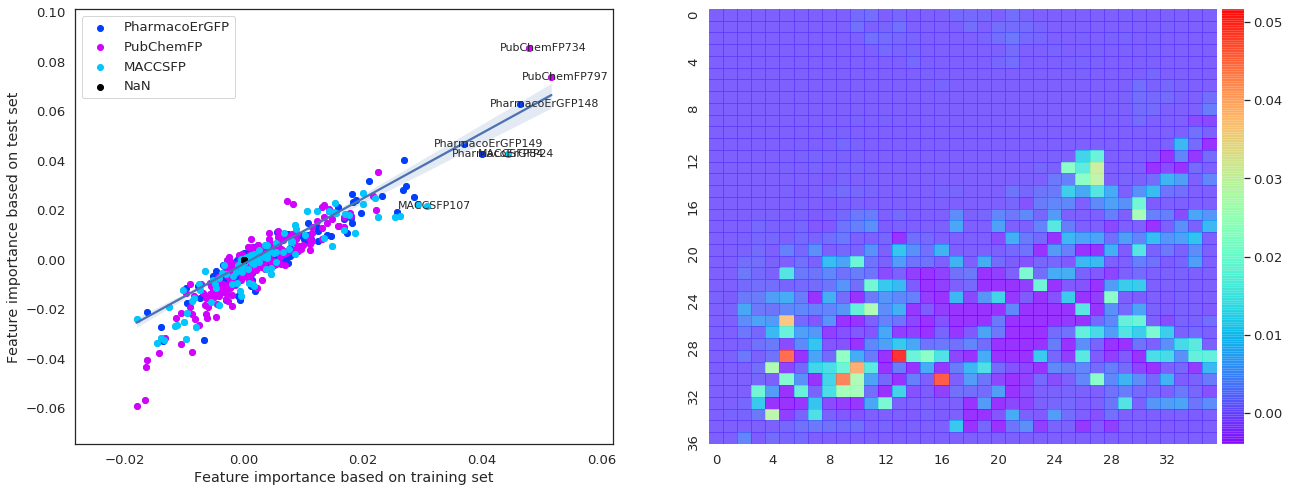

In [18]:
sns.set(style='white',  font='sans-serif', font_scale=1.2)


from scipy.stats import pearsonr
pcc, p = pearsonr(dfp['Feature importance based on training set'], dfp['Feature importance based on test set'])



fig, (ax, ax2)  = plt.subplots(1, 2, figsize=(21, 8))
sns.regplot(dfp['Feature importance based on training set'], 
            dfp['Feature importance based on test set'], ax = ax)

for subtype, color in colormaps.items():
    dfi = dfp[dfp['Subtypes'] == subtype]

    x = dfi['Feature importance based on training set']
    y = dfi['Feature importance based on test set']
    ax.scatter(x, y, label = subtype, color = color)

for i,j in dfp.iterrows():
    x = j['Feature importance based on training set']
    y = j['Feature importance based on test set']
    if (x > 0.03) | (y > 0.052):
        ax.text(x-0.005,y,i, fontsize = 11, verticalalignment = 'center')
    
# p = '%.3f' % p
# pcc = '%.3f' % pcc
# ax.text(0.00,0.09,'peasonr = %s; p = %s' % (pcc, p), bbox = {'boxstyle': 'round', 'facecolor': 'white', 'edgecolor':'gray'})
ax.legend()

# ax.set_xlim(-0.01, 0.07)
# ax.set_ylim(-0.01, 0.07)


imp = train_imp.join(test_imp.importance.to_frame(name = 'test_importance'))
IMPM = imp.importance.values.reshape(37,36)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, 
            yticklabels=4, vmin = -0.004,
            ax = ax2,  
            cbar_kws = {'fraction':0.046, 'pad':0.01})

bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)


plt.subplots_adjust(wspace = 0.18)
plt.savefig('../result/feature_importance.svg', dpi = 400, bbox_inches="tight")


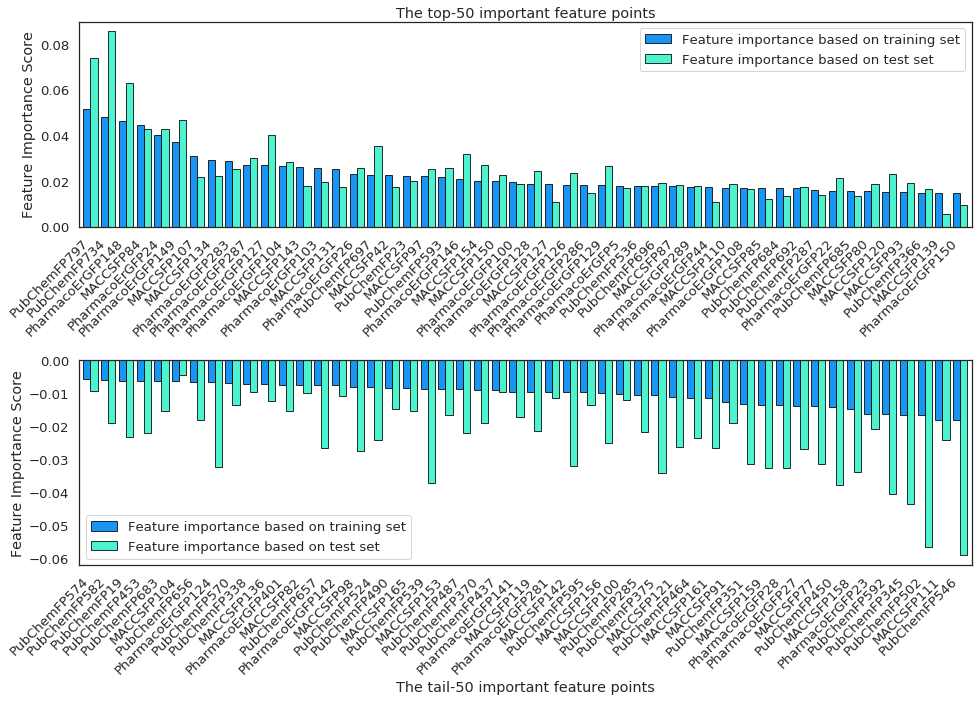

In [19]:
colors = sns.color_palette('rainbow', 4).as_hex()

f, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(16,10))

df1 = dfp.sort_values('Feature importance based on training set',  ascending = False).head(50)
ax1 = df1.plot(kind = 'bar',ax = ax1, color = colors[0:2], width = 0.8, edgecolor='black', lw = 0.8)


df2 = dfp.sort_values('Feature importance based on training set', ascending = False).tail(50)
ax2 = df2.plot(kind = 'bar', ax = ax2, color = colors[0:2], width = 0.8, edgecolor='black', lw = 0.8 )

ax1.set_xticklabels(df1.index, rotation=45, ha='right')
ax2.set_xticklabels(df2.index, rotation=45, ha='right')

ax1.set_xlabel(None, fontsize='medium')
ax2.set_xlabel(None, fontsize='medium')

ax1.set_ylabel('Feature Importance Score', fontsize='medium')
ax2.set_ylabel('Feature Importance Score', fontsize='medium')


ax1.set_xlabel('The top-50 important feature points')
ax2.set_xlabel('The tail-50 important feature points')
ax1.xaxis.set_label_position('top')


plt.subplots_adjust(hspace = 0.65)

plt.savefig('../result/feature_importance_rank.svg', dpi = 400, bbox_inches="tight")

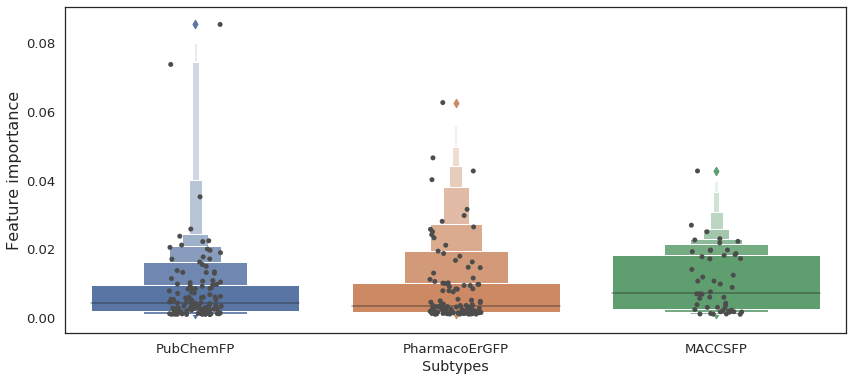

In [20]:
sns.set(style='white',  font='sans-serif', font_scale=1.2,)
f, ax = plt.subplots(1, 1, figsize=(14, 6))

dfd = dfp[dfp['Feature importance based on test set'] > 0.001]
order = dfd.groupby('Subtypes')['Feature importance based on test set'].apply(np.max).sort_values(ascending=False).index.tolist()


sns.boxenplot(x="Subtypes", y="Feature importance based on test set",  data = dfd, ax = ax, order = order)
sns.stripplot(x="Subtypes", y="Feature importance based on test set",  data = dfd, ax = ax, order = order, color = '0.3')
ax.set_ylabel('Feature importance', fontdict={"fontsize":16})

plt.savefig('../result/feature_importance_distribution.svg', dpi = 400, bbox_inches="tight")

In [21]:
from rdkit import Chem
import molmap

In [22]:
dfpub = molmap.feature.fingerprint.pubchemfp.GetPubChemFPInfos()
dfmac = molmap.feature.fingerprint.maccskeys.GetMACCSFPInfos()
dfmac['Bit Substructure'] = dfmac['Bit Smarts']

_, bits = molmap.feature.fingerprint.pharmErGfp.GetPharmacoErGFPs(Chem.MolFromSmiles('C'), return_bitInfo=True)
dfpar = pd.DataFrame([bits]).T
dfpar.index = mp2.extract.bitsinfo[mp2.extract.bitsinfo.Subtypes == 'PharmacoErGFP'].IDs
dfpar.index.name = 'Bits'
dfpar.columns = ['Bit Substructure']
dfpar = dfpar.reset_index()

dfmap1 = dfpub.set_index('Bits')['Bit Substructure']
dfmap2 = dfmac.set_index('Bits')['Bit Substructure']
dfmap3 = dfpar.set_index('Bits')['Bit Substructure']

dfmap = dfmap1.append(dfmap2).append(dfmap3)

In [23]:
import molmap
E = molmap.feature.fingerprint.Extraction({'PubChemFP':{}, 'MACCSFP':{}, "PharmacoErGFP":{}})

In [24]:
X = E.batch_transform(df.smiles)

100%|##########| 1513/1513 [00:11<00:00, 126.23it/s]


In [25]:
dfx = pd.DataFrame(X, columns = E.bitsinfo.IDs)*1

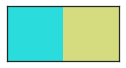

In [26]:
s = sns.color_palette("rainbow", n_colors=2)
sns.palplot(s)

In [27]:
dfa = dfp[dfp.index != 0].join(df_grid.set_index('v')[['x','y']])
dfa = dfa.sort_values('Feature importance based on training set',  ascending = False)
dfa = dfa.join(dfmap)

res = []
for key in dfa.index:
    dfxx = pd.DataFrame(Y).join(dfx[key])   
    res_ = dfxx.groupby(0)[key].apply(lambda x:(x.sum())/len(x)).to_dict()
    res_.update({'IDs':key})
    res.append(res_)
    
df_ratio = pd.DataFrame(res)
df_ratio = df_ratio.set_index('IDs')
df_ratio = df_ratio.rename(columns = {0:'Proportion in non-inhibitors', 1:'Proportion in inhibitors'})
df_ratio = df_ratio[['Proportion in inhibitors', 'Proportion in non-inhibitors']]

In [28]:
dfa = dfa.join(df_ratio)

In [29]:
dfa.to_csv('./feature_importance.csv')

## the top-50

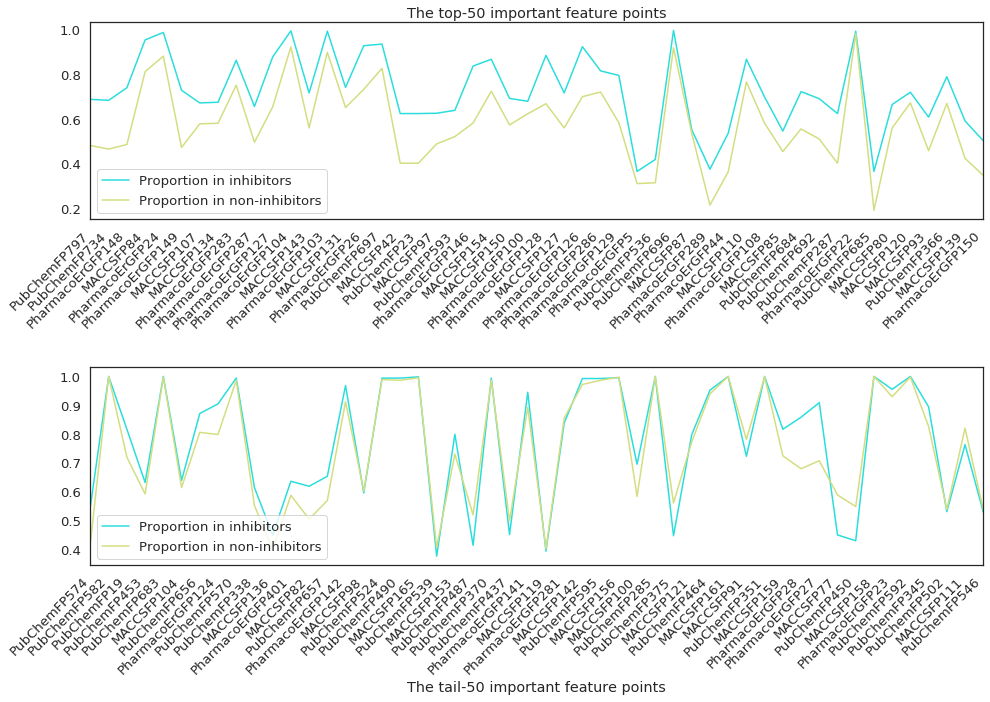

In [30]:
f, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(16,10))
sns.set(style='white',  font='sans-serif', font_scale=1.2,)

df1 = dfa[['Proportion in inhibitors', 'Proportion in non-inhibitors']].head(50)
df1.plot(kind = 'line',color= s.as_hex(), ax = ax1,)

ax1.set_xticks(list(range(len(df1))))

ax1.set_xticklabels(df1.index, rotation=45, ha='right')

ax1.set_xlabel('The top-50 important feature points')
ax1.xaxis.set_label_position('top')



df2 = dfa[['Proportion in inhibitors', 'Proportion in non-inhibitors']].tail(50)
df2.plot(kind = 'line',color= s.as_hex(), ax = ax2,)

ax2.set_xticks(list(range(len(df2))))
ax2.set_xticklabels(df2.index, rotation=45, ha='right')
ax2.set_xlabel('The tail-50 important feature points')

ax1.legend(loc = 'lower left')
ax2.legend(loc = 'lower left')

plt.subplots_adjust(hspace = 0.75)
plt.savefig('../result/feature_importance_proportion.svg', dpi = 400, bbox_inches="tight")